In [8]:
    # kernel_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},           
    # bias_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},  
    # kernel_regularizer=l1_l2(
    #     l1={{uniform(0, 0.1)}}, 
    #     l2={{uniform(0, 0.1)}}),
    # bias_regularizer=l1_l2(
    #     l1={{uniform(0, 0.1)}}, 
    #     l2={{uniform(0, 0.1)}}),
    # activity_regularizer=l1_l2(
    #     l1={{uniform(0, 0.1)}}, 
    #     l2={{uniform(0, 0.1)}},
    # ),

    # adamax = keras.optimizers.Adamax(
    #     learning_rate={{uniform(0.001, 0.1)}},
    #     beta_1={{uniform(0.75, 1)}},
    #     beta_2={{uniform(0.75, 1)}})

In [9]:
import time 
import pickle 
import logging 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from joblib import dump, load


from sklearn import metrics
from sklearn.utils import shuffle, class_weight 
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate 
from sklearn.impute import KNNImputer 
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline

pd.options.display.float_format = '{:20,.15f}'.format 
pd.options.display.max_columns = None

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adamax 
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.compat.v1.keras import backend as K

tf.autograph.set_verbosity(1) 
tf.get_logger().setLevel(logging.ERROR) 
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8)
session_conf.gpu_options.per_process_gpu_memory_fraction = 0.5
K.set_session(tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf))

from hyperopt import Trials, STATUS_OK, tpe, rand 
from hyperas import optim 
from hyperas.distributions import choice, uniform

from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer

plt.rcParams["figure.figsize"] = (7,3)

In [10]:
from importlib import reload
import binary_output, run_models, output
from binary_output import (
    calc_binary_metrics, calc_confusion_values, get_binary_metrics_for_threshold, get_binary_cv_metrics, get_print_binary_metrics,
    keras_error_rate, keras_matthews_correlation, keras_f1_score, keras_conf_matrix)
from run_models import get_classification_cv_predictions
from output import print_train_history
reload(binary_output)
reload(output)
reload(run_models)
from binary_output import (
    calc_binary_metrics, calc_confusion_values, get_binary_metrics_for_threshold, get_binary_cv_metrics, get_print_binary_metrics,
    keras_error_rate, keras_matthews_correlation, keras_f1_score, keras_conf_matrix)
from run_models import get_classification_cv_predictions
from output import print_train_history

In [11]:
# with open(f'classification/binary_data_dropped.pickle', 'rb') as handle:
#    data = pickle.load(handle)

# X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']

# X = pd.concat([X_train, X_test, X_val])
# y = np.concatenate([y_train, y_test, y_val])

In [12]:
with open(f'classification/binary_data_dropped_nan_filled.pickle', 'rb') as handle:
    data = pickle.load(handle)

X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']
X = pd.concat([X_train, X_test, X_val])
y = np.concatenate([y_train, y_test, y_val])

In [1]:
def create_binary_nn(input_shape):
    def get_model():
        model = tf.keras.Sequential()
        model.add(Dense(1024, input_shape=input_shape, activation='tanh'))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(192, activation='elu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(reduction='none', label_smoothing=0.02),
            metrics=[
                keras_f1_score,
                keras_matthews_correlation,
                tf.keras.metrics.TruePositives(name='tp'),
                tf.keras.metrics.TrueNegatives(name='tn'),
                tf.keras.metrics.FalsePositives(name='fp'),
                tf.keras.metrics.FalseNegatives(name='fn'),
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                keras_error_rate,
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc'),
            ],
            optimizer='adamax',
        )
        return model
    return get_model

def fit_binary_nn(model, X, y, X_val=None, y_val=None, patience=30, verbose=0):
    es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=patience)

    counts = np.bincount(y)
    class_weights = {0: 1.0 / counts[0], 1: 1.0 / counts[1]}

    fit_params = {
        'batch_size': 512,
        'epochs': 10000,
        'verbose': verbose,
        'shuffle': True,
        'class_weight': class_weights,
        'callbacks': [es],
        'use_multiprocessing': True,
    }
    eval_set = (X_val, y_val) if not X_val.empty and y_val.any() else None
    if eval_set:
        fit_params['validation_data'] = eval_set
    else:
        fit_params['validation_split'] = 0.05
    history = model.fit(X, y, **fit_params)
    return model, history

def create_and_fit_binary_nn(X, y, X_val=None, y_val=None, patience=100, model_params={}, verbose=0):
    return fit_binary_nn(create_binary_nn(input_shape=[X.shape[1]])(), X, y, X_val, y_val, patience=patience, verbose=verbose)

def create_and_fit_binary_nn_pipe(X, y, X_val=None, y_val=None, patience=100, model_params={}, verbose=0):
    es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=patience)
    counts = np.bincount(y)
    class_weights = {0: 1.0 / counts[0], 1: 1.0 / counts[1]}

    pipe = Pipeline([
        ('powertransform', PowerTransformer()),
        ('model', KerasClassifier(
                create_binary_nn([X.shape[1]]),
                batch_size=512,
                epochs=10000,
                verbose=1,
                shuffle=True,
                class_weight=class_weights,
                callbacks=[es],
                use_multiprocessing=True,
                validation_data=(X_val, y_val),
            )
        ),
    ])
    pipe.fit(X, y)
    return pipe

In [18]:
def create_and_fit_binary_nn_with_params(X, y, X_val=None, y_val=None, patience=30, model_params=None, verbose=0, validation_split=None):
    start = time.time()
    counts = np.bincount(y)
    class_weights = {0: 1.0 / counts[0], 1: 1.0 / counts[1]}
    # batch_size = model_params.pop('batch_size')
    es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=patience)
    fit_params = {
        # 'batch_size': batch_size,
        'batch_size': 16,
        'epochs': 10000,
        'verbose': verbose,
        'shuffle': True,
        'class_weight': class_weights,
        'callbacks': [es],
        'use_multiprocessing': True,
    }
    if X_val is None and y_val is None:
        fit_params['validation_split'] = validation_split
    else:
        fit_params['validation_data'] = (X_val, y_val)
    model = Pipeline([
        ('powertransform', PowerTransformer()),
        ('model', KerasClassifier(build_nn_model_with_params([X.shape[1]], model_params), **fit_params))
    ]).fit(X, y)
    end = time.time()
    print(f'model fit time: {end - start}')
    return model

def build_nn_model_with_params(input_shape, params):
    def get_model():
        adamax = Adamax(learning_rate=params['adamax_learning_rate'], beta_1=params['adamax_beta_1'], beta_2=params['adamax_beta_2'])
        hidden_layers = []
        for l in range(1, params['hidden_layers']+1):
            hidden_layers.append(Dense(
                params[f'l{l}_neurons'],
                activation=params[f'l{l}_activation'],
                kernel_initializer=params[f'l{l}_kernel_init'],
                name=f'Dense_{l}',
            ))
            hidden_layers.append(Dropout(params[f'l{l}_dropout'], name=f'Dropout_{l}'))
        
        input_layer = Input(input_shape)
        output_layer = Dense(1, activation='sigmoid', kernel_initializer=params['output_kernel_init'], name='Output')
        model = Sequential([input_layer] + hidden_layers + [output_layer])

        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(reduction='none', label_smoothing=0.02),
            metrics=[
                keras_f1_score,
                keras_matthews_correlation,
                tf.keras.metrics.TruePositives(name='tp'),
                tf.keras.metrics.TrueNegatives(name='tn'),
                tf.keras.metrics.FalsePositives(name='fp'),
                tf.keras.metrics.FalseNegatives(name='fn'),
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                keras_error_rate,
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc'),
            ],
            optimizer=adamax,
        )
        return model
    return get_model
    # def get_model():
    #     adamax = Adamax(learning_rate=0.001,beta_1=0.958,beta_2=0.987)
    #     model = Sequential([
    #         Dense(1024, activation='tanh', input_shape=input_shape),
    #         Dropout(0.5),
    #         Dense(512, activation='relu'),
    #         Dropout(0.5),
    #         Dense(192, activation='relu'),
    #         Dropout(0.5),
    #         Dense(1, activation='sigmoid'),
    #     ])

    #     model.compile(
    #         loss=tf.keras.losses.BinaryCrossentropy(reduction='none', label_smoothing=0.02),
    #         metrics=[
    #             keras_f1_score,
    #             keras_matthews_correlation,
    #             tf.keras.metrics.TruePositives(name='tp'),
    #             tf.keras.metrics.TrueNegatives(name='tn'),
    #             tf.keras.metrics.FalsePositives(name='fp'),
    #             tf.keras.metrics.FalseNegatives(name='fn'),
    #             tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    #             keras_error_rate,
    #             tf.keras.metrics.Precision(name='precision'),
    #             tf.keras.metrics.Recall(name='recall'),
    #             tf.keras.metrics.AUC(name='auc'),
    #         ],
    #         optimizer='adamax',
    #     )
    #     return model
    # return get_model

In [19]:
%%time

predictions, _ = get_classification_cv_predictions(
    create_and_fit_binary_nn_with_params, X, y,
    n_splits=10, 
    validation_split=0.05,
    patience=1,
    model_params={},
    verbose=1,
)
pred_metrics = get_binary_cv_metrics(
    predictions, 
    print_graphs=True,
)

split num: 1
Epoch 1/10000
373/373 [==============================] - 2s 5ms/step - loss: 2.2417e-04 - keras_f1_score: 0.6821 - keras_matthews_correlation: 0.2174 - tp: 2576.0000 - tn: 1110.0000 - fp: 699.0000 - fn: 1569.0000 - accuracy: 0.6191 - keras_error_rate: 0.3812 - precision: 0.7866 - recall: 0.6215 - auc: 0.6641 - val_loss: 0.5296 - val_keras_f1_score: 0.7644 - val_keras_matthews_correlation: 0.4796 - val_tp: 144.0000 - val_tn: 85.0000 - val_fp: 14.0000 - val_fn: 71.0000 - val_accuracy: 0.7293 - val_keras_error_rate: 0.2694 - val_precision: 0.9114 - val_recall: 0.6698 - val_auc: 0.8598
Epoch 2/10000
373/373 [==============================] - 1s 3ms/step - loss: 1.9386e-04 - keras_f1_score: 0.7298 - keras_matthews_correlation: 0.3360 - tp: 2749.0000 - tn: 1271.0000 - fp: 538.0000 - fn: 1396.0000 - accuracy: 0.6752 - keras_error_rate: 0.3252 - precision: 0.8363 - recall: 0.6632 - auc: 0.7473 - val_loss: 0.5129 - val_keras_f1_score: 0.7997 - val_keras_matthews_correlation: 0.5225

KeyboardInterrupt: 

In [27]:
get_binary_metrics_for_threshold(pred_metrics, 0.48)

accuracy: 0.7302301324230281
f1: 0.7903497001088551
roc_auc: 0.7282314355023061
cohen_kappa: 0.41816494631968093
matthews: 0.42885394197416965
precision: 0.8583089899614427
recall: 0.7333496634574422
tn: 153.3
fp: 58.7
fn: 129.2
tp: 355.3
error_rate: 187.9


In [58]:
get_binary_metrics_for_threshold(pred_metrics, 0.59)

accuracy: 0.7376952126519236
f1: 0.7964982388698164
roc_auc: 0.7362561187729177
cohen_kappa: 0.4328568000531954
matthews: 0.44466955590654766
precision: 0.8645121935470582
recall: 0.7399650677345146
tn: 155.3
fp: 56.7
fn: 126.0
tp: 358.5
error_rate: 182.7


In [15]:
def convert_nn_params(params):
    initializers = ['glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform']
    activations = ['relu', 'elu', 'selu', 'sigmoid', 'tanh']

    get_float = lambda val: max(min(val, 1), 0)
    get_int = lambda val: int(round(val))
    get_initializer = lambda i: initializers[max(min(get_int(i), 5), 0)]
    get_activation = lambda i: activations[max(min(get_int(i), 4), 0)]

    return_params = {
        'hidden_layers': get_int(params['hidden_layers']),
        'adamax_learning_rate': max(params['adamax_learning_rate'], 0),
        'adamax_beta_1': get_float(params['adamax_beta_1']),
        'adamax_beta_2': get_float(params['adamax_beta_2']),
        'batch_size': get_int(params['batch_size']),
        'output_kernel_init': get_initializer(params['output_kernel_init']),
    }
    for l in range(1, get_int(params['hidden_layers'])+1):
        return_params[f'l{l}_neurons'] = get_int(params[f'l{l}_neurons'])
        return_params[f'l{l}_activation'] = get_activation(params[f'l{l}_activation'])
        return_params[f'l{l}_kernel_init'] = get_initializer(params[f'l{l}_kernel_init'])
        return_params[f'l{l}_dropout'] = get_float(params[f'l{l}_dropout'])

    return return_params

In [16]:
# Fine tune with bayes optimizator
def bayes_parameter_opt_nn_classification(X, y, init_round=15, opt_round=30, n_folds=10, patience=5, validation_size=0.05, output_process=False):
    def nn_eval(**params_raw):
        params = convert_nn_params(params_raw)
        print(params)
        predictions, _ = get_classification_cv_predictions(create_and_fit_binary_nn_with_params, X, y, n_splits=n_folds, validation_size=validation_size, patience=patience, model_params=params)
        pred_metrics = get_binary_cv_metrics(predictions, print_graphs=False)
        threshold = 50
        print('#######################################')
        for metric in pred_metrics:
            print(f'{metric}: {pred_metrics[metric][threshold]}')
        return pred_metrics['roc_auc'][threshold]

    pbounds = {
        'adamax_learning_rate': (0.0005, 0.02),
        'adamax_beta_1': (0.8, 1),
        'adamax_beta_2': (0.95, 1),
        'output_kernel_init': (0, 5),
        'batch_size': (4, 1024),
        'hidden_layers': (1, 3),
    }
    for l in range(1, 4):
        pbounds[f'l{l}_neurons'] = (64, 1024)
        pbounds[f'l{l}_activation'] = (0, 4)
        pbounds[f'l{l}_kernel_init'] = (0, 5)
        pbounds[f'l{l}_dropout'] = (0.1, 0.8)

    bounds_transformer = SequentialDomainReductionTransformer()
    optimizer = BayesianOptimization(
        f = nn_eval, 
        pbounds = pbounds, 
        random_state=0,
        bounds_transformer=bounds_transformer,
    )
    optimizer.maximize(init_points=init_round, n_iter=opt_round)
    model_params=[]
    for model in range(len(optimizer.res)):
        model_params.append(optimizer.res[model]['target'])
    return {
        'target': optimizer.res[pd.Series(model_params).idxmax()]['target'], 
        'params': optimizer.res[pd.Series(model_params).idxmax()]['params'],
        'bounds_transformer': bounds_transformer,
        'optimizer': optimizer,
    }

In [212]:
%%time
nn_optimized = bayes_parameter_opt_nn_classification(X, y, init_round=2, opt_round=75, n_folds=10)

fit time: 4.111873149871826
split num: 8
Epoch 00019: early stopping
model fit time: 7.080571174621582
split num: 9
Epoch 00019: early stopping
model fit time: 7.042860984802246
split num: 10
Epoch 00018: early stopping
model fit time: 6.751587629318237
#######################################
accuracy: 0.7415712247893269
f1: 0.8007994597166688
roc_auc: 0.7314814624289258
cohen_kappa: 0.433320142961741
matthews: 0.44521900757611743
precision: 0.8576534386670926
recall: 0.757302547499361
tn: 149.6
fp: 62.4
fn: 117.6
tp: 366.9
error_rate: 180.0
|  67       |  0.7315   |  0.9347   |  0.9872   |  0.0149   |  550.2    |  1.635    |  2.576    |  0.4997   |  4.378    |  955.1    |  2.309    |  0.5123   |  3.048    |  550.8    |  3.574    |  0.1904   |  1.261    |  94.73    |  4.211    |
{'hidden_layers': 2, 'adamax_learning_rate': 0.014891432308828742, 'adamax_beta_1': 0.9347709053950074, 'adamax_beta_2': 0.9872228257328813, 'batch_size': 550, 'output_kernel_init': 'lecun_normal', 'l1_neurons'

In [260]:
get_binary_metrics_for_threshold(pred_metrics, 0.48)

accuracy: 0.7613812892692822
f1: 0.8192258409317275
roc_auc: 0.750090927577842
cohen_kappa: 0.4703520317630411
matthews: 0.4772623782063562
precision: 0.8653949073090924
recall: 0.7789554400613444
tn: 152.9
fp: 59.1
fn: 107.1
tp: 377.4
error_rate: 166.2


In [216]:
def print_formatted(obj):
    for p in obj:
        val = obj[p]
        if isinstance(val, float):
            val = round(val, 3)
        elif isinstance(val, str):
            val = f'\'{val}\''
        print(f'{p}={val},')

def print_output(obj):
    for p in obj:
        print(f'{p}: {obj[p]}')
   
def print_formatted_params(params):
    print_formatted(convert_nn_params(params))

In [315]:
predictions, histories = get_classification_cv_predictions(create_and_fit_binary_nn, X, y, n_splits=10, validation_split=0.05, patience=10, verbose=1)
pred_metrics = get_binary_cv_metrics(predictions)

step - loss: 2.2240e-04 - keras_f1_score: 0.6793 - keras_matthews_correlation: 0.2125 - tp: 2475.0000 - tn: 1154.0000 - fp: 666.0000 - fn: 1660.0000 - accuracy: 0.6094 - keras_error_rate: 0.3914 - precision: 0.7880 - recall: 0.5985 - auc: 0.6614 - val_loss: 0.6528 - val_keras_f1_score: 0.6954 - val_keras_matthews_correlation: 0.2286 - val_tp: 137.0000 - val_tn: 57.0000 - val_fp: 31.0000 - val_fn: 89.0000 - val_accuracy: 0.6178 - val_keras_error_rate: 0.3822 - val_precision: 0.8155 - val_recall: 0.6062 - val_auc: 0.6521
Epoch 18/10000
12/12 [==============================] - 0s 31ms/step - loss: 2.1836e-04 - keras_f1_score: 0.6883 - keras_matthews_correlation: 0.2421 - tp: 2505.0000 - tn: 1191.0000 - fp: 629.0000 - fn: 1630.0000 - accuracy: 0.6207 - keras_error_rate: 0.3794 - precision: 0.7993 - recall: 0.6058 - auc: 0.6757 - val_loss: 0.6559 - val_keras_f1_score: 0.6821 - val_keras_matthews_correlation: 0.2124 - val_tp: 133.0000 - val_tn: 57.0000 - val_fp: 31.0000 - val_fn: 93.0000 - v

IndexError: index 1 is out of bounds for axis 1 with size 1

History of fold 0


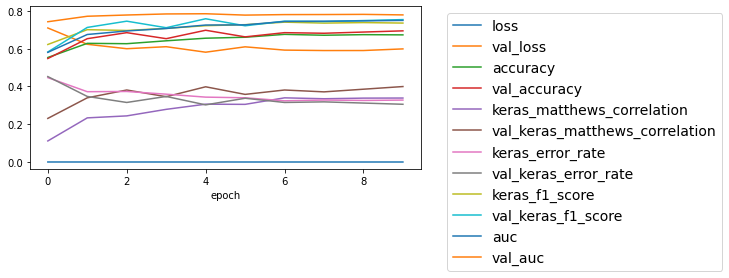

History of fold 1


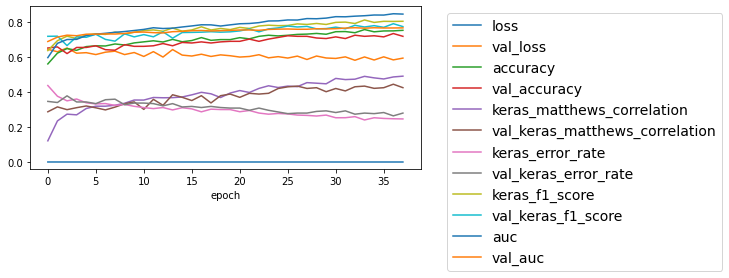

History of fold 2


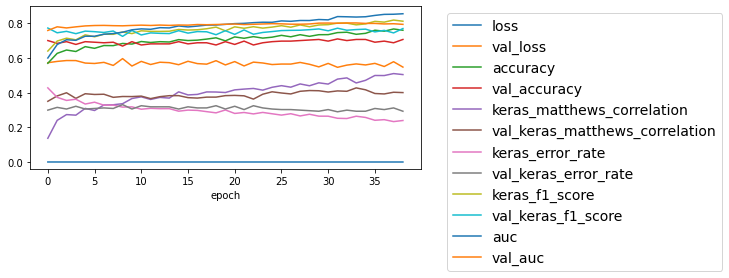

History of fold 3


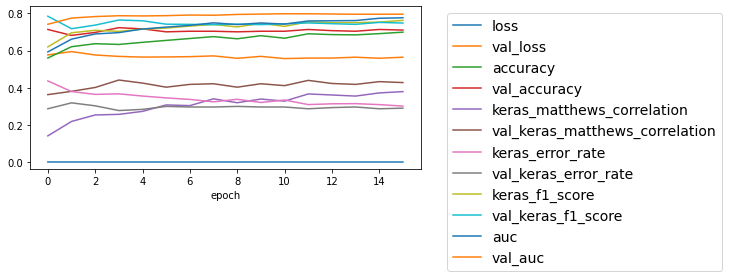

History of fold 4


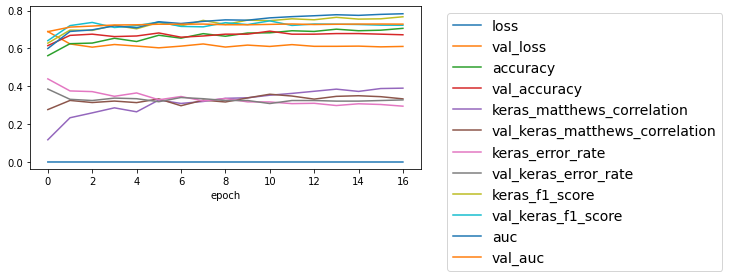

History of fold 5


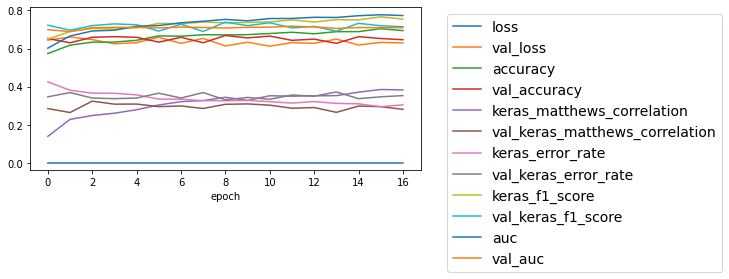

History of fold 6


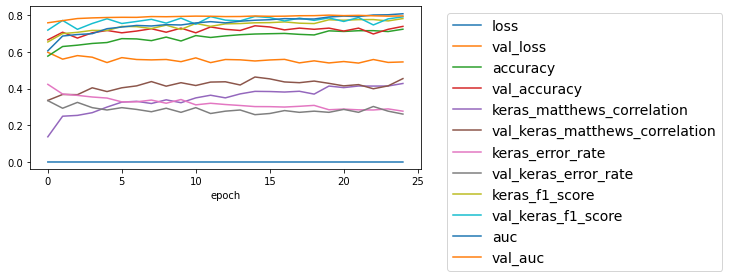

History of fold 7


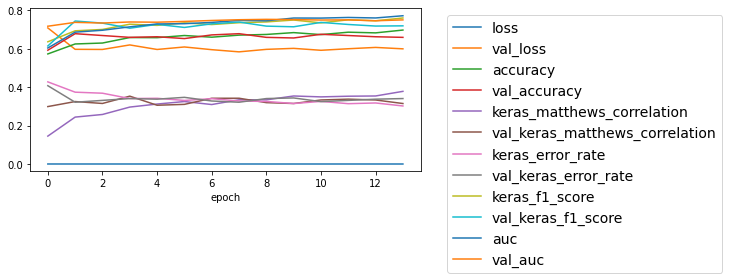

History of fold 8


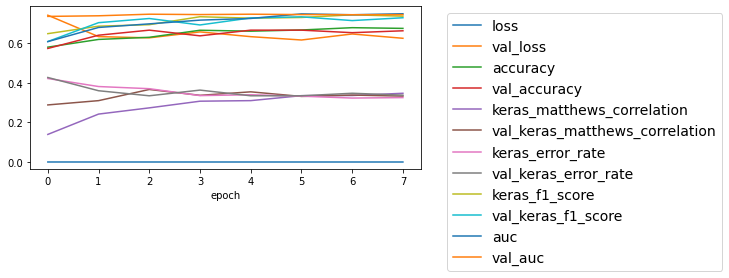

History of fold 9


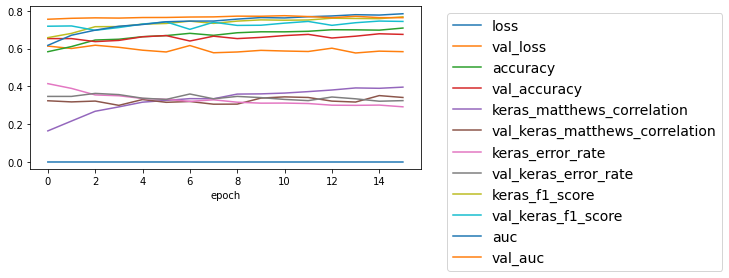

accuracy: max 0.7444431389040057 at threshold 0.3
accuracy: min 0.3043791949075677 at threshold 1.0
f1: max 0.8334432966676282 at threshold 0.2
f1: min 0.0 at threshold 1.0
roc_auc: max 0.6920863910452513 at threshold 0.51
roc_auc: min 0.5 at threshold 0.0
cohen_kappa: max 0.3559760160736351 at threshold 0.42
cohen_kappa: min 0.0 at threshold 0.0
matthews: max 0.36017243437422614 at threshold 0.45
matthews: min 0.0 at threshold 0.0
precision: max 0.9719747899159664 at threshold 0.99
precision: min 0.0 at threshold 1.0
recall: max 1.0 at threshold 0.0
recall: min 0.0 at threshold 1.0


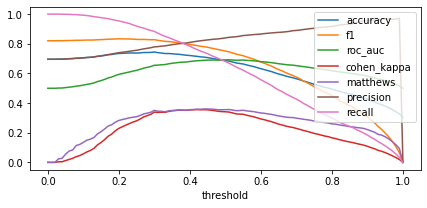

tp: max 484.5 at threshold 0.0
tp: min 0.0 at threshold 1.0
tn: max 212.0 at threshold 1.0
tn: min 0.0 at threshold 0.0
fp: max 212.0 at threshold 0.0
fp: min 0.0 at threshold 1.0
fn: max 484.5 at threshold 1.0
fn: min 0.0 at threshold 0.0
error_rate: max 484.5 at threshold 1.0
error_rate: min 178.0 at threshold 0.3


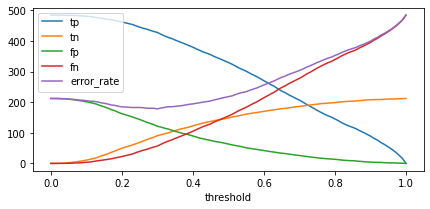

In [202]:
for i, history in enumerate(histories):
    print(f'History of fold {i}')
    print_train_history(history)
predictions = convert_predictions(predictions)
pred_metrics = get_binary_cv_metrics(predictions)

In [205]:
# patience 5
get_binary_metrics_for_threshold(pred_metrics, 0.42)

accuracy: 0.7152968798957766
f1: 0.7878556603824911
roc_auc: 0.6856570135404727
cohen_kappa: 0.3559760160736351
matthews: 0.35874015639803986
precision: 0.8172100401507516
recall: 0.761408366703587
tn: 129.3
fp: 82.7
fn: 115.6
tp: 368.9
error_rate: 198.3


In [127]:
# Fine tuning binary classifier

def get_data():
    with open(f'classification/binary_data.pickle', 'rb') as handle:
        data = pickle.load(handle)

    X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']
    return X_train, y_train, X_val, y_val, X_test, y_test

def get_model(X_train, y_train, X_val, y_val, X_test, y_test):
    model = tf.keras.Sequential()
    model.add(Dense(
        1024,
        input_shape=[X_train.shape[1]],
    ))
    model.add(Activation({{choice(['relu', 'elu', 'selu', 'sigmoid', 'swish', 'tanh'])}}))
    model.add(Dropout(0.5))

    model.add(Dense(
        512,
    ))
    model.add(Activation({{choice(['relu', 'elu', 'selu', 'sigmoid', 'swish', 'tanh'])}}))
    model.add(Dropout(0.5))

    model.add(Dense(
        192,
    ))
    model.add(Activation({{choice(['relu', 'elu', 'selu', 'sigmoid', 'swish', 'tanh'])}}))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))


    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(reduction='none', label_smoothing=0.02),
        metrics=[
            keras_f1_score,
            keras_matthews_correlation,
            tf.keras.metrics.TruePositives(name='tp'),
            tf.keras.metrics.TrueNegatives(name='tn'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.FalseNegatives(name='fn'),
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            keras_error_rate,
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
        ],
        optimizer='adamax',
    )
    counts = np.bincount(y_train)
    weight_for_0 = 1.0 / counts[0]
    weight_for_1 = 1.0 / counts[1]

    es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=30)
    model.fit(
        X_train,
        y_train,
        batch_size=512,
        epochs=5000,
        verbose=0,
        validation_data=(X_val, y_val),
        class_weight={0: weight_for_0, 1: weight_for_1},
        callbacks=[es],
    )

    res = model.evaluate(X_test, y_test, verbose=1)
    metrics = ['crossbinary loss', 'f1 score', 'matthews', 'tp', 'tn', 'fp', 'fn', 'accuracy', 'error rate', 'precision', 'recall', 'auc']
    for i, metric in enumerate(metrics):
        print(f'{metric}: {res[i]}')
    matthews_loss = -res[2]
    print(f'matthews loss: {matthews_loss}')
    return {'loss': matthews_loss, 'status': STATUS_OK, 'model': model}

In [128]:
best_run = None
best_model = None
space = None
trials=Trials()
best_run, best_model, space = optim.minimize(model=get_model,
                                      data=get_data,
                                      algo=tpe.suggest,
                                      max_evals=15,
                                      trials=trials,
                                      notebook_name='classification',
                                      eval_space=True,
                                      return_space=True,
                                      functions=[keras_error_rate, keras_matthews_correlation, keras_f1_score, keras_conf_matrix])

'Activation_1']))
  15:     model.add(Dropout(0.5))
  16: 
  17:     model.add(Dense(
  18:         192,
  19:     ))
  20:     model.add(Activation(space['Activation_2']))
  21:     model.add(Dropout(0.5))
  22:     
  23:     model.add(Dense(1, activation='sigmoid'))
  24: 
  25: 
  26:     model.compile(
  27:         loss=tf.keras.losses.BinaryCrossentropy(reduction='none', label_smoothing=0.02),
  28:         metrics=[
  29:             keras_f1_score,
  30:             keras_matthews_correlation,
  31:             tf.keras.metrics.TruePositives(name='tp'),
  32:             tf.keras.metrics.TrueNegatives(name='tn'),
  33:             tf.keras.metrics.FalsePositives(name='fp'),
  34:             tf.keras.metrics.FalseNegatives(name='fn'),
  35:             tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  36:             keras_error_rate,
  37:             tf.keras.metrics.Precision(name='precision'),
  38:             tf.keras.metrics.Recall(name='recall'),
  39:             tf

In [389]:
best_run

{'Dense': 256,
 'Dense_1': 1024,
 'Dense_2': 192,
 'Dropout': 0.8879956343562,
 'Dropout_1': 0.2864809526545459,
 'Dropout_2': 'four',
 'Dropout_3': 0.4218273297119354,
 'batch_size': 512,
 'beta_1': 0.9867606922864711,
 'beta_1_1': 0.8777089234473114,
 'kernel_initializer': 'zeros',
 'kernel_initializer_1': 'glorot_normal',
 'l1': 0.0888871639782978,
 'l1_1': 0.03686428231765312,
 'l1_2': 0.03840653655364615,
 'l1_3': 0.04143619965361733,
 'l1_4': 0.009225974322037533,
 'l1_5': 0.020942239619394943,
 'learning_rate': 0.05705256128722609}

In [235]:
# Test NN binary classifier

# hidden_layers=2,
# adamax_learning_rate=0.015,
# adamax_beta_1=0.935,
# adamax_beta_2=0.987,
# batch_size=550,
# output_kernel_init='lecun_normal',
# l1_neurons=955,
# l1_activation='sigmoid',
# l1_kernel_init='lecun_normal',
# l1_dropout=0.5,
# l2_neurons=551,
# l2_activation='selu',
# l2_kernel_init='he_uniform',
# l2_dropout=0.512,

model = tf.keras.Sequential()
model.add(Dense(
    955,
    input_shape=[X_train.shape[1]], 
    activation='sigmoid',
    kernel_initializer='lecun_normal',
))
model.add(Dropout(0.5))
model.add(Dense(
    551, 
    activation='selu',
    kernel_initializer='lecun_normal',
))
model.add(Dropout(0.512))
model.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(reduction='none', label_smoothing=0.02),
    metrics=[
        keras_f1_score,
        keras_matthews_correlation,
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        keras_error_rate,
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ],
    optimizer=Adamax(learning_rate=0.015, beta_1=0.935, beta_2=0.987)
)
counts = np.bincount(y_train)
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=30)
history = model.fit(
    X_train,
    y_train,
    batch_size=550,
    epochs=10000,
    verbose=1,
    shuffle=True,
    validation_data=(X_val, y_val),
    class_weight={0: weight_for_0, 1: weight_for_1},
    callbacks=[es],
    use_multiprocessing=True,
)

res = model.evaluate(X_test.values, y_test, verbose=1)
metrics = ['crossbinary loss', 'f1 score', 'matthews', 'tp', 'tn', 'fp', 'fn', 'accuracy', 'error rate', 'precision', 'recall', 'auc']
for i, metric in enumerate(metrics):
    print(f'{metric}: {res[i]}')

: 1197.0000 - fp: 503.0000 - fn: 1598.0000 - accuracy: 0.6229 - keras_error_rate: 0.3714 - precision: 0.8189 - recall: 0.5873 - auc: 0.6925 - val_loss: 0.5567 - val_keras_f1_score: 0.8024 - val_keras_matthews_correlation: 0.3613 - val_tp: 377.0000 - val_tn: 127.0000 - val_fp: 90.0000 - val_fn: 103.0000 - val_accuracy: 0.7231 - val_keras_error_rate: 0.2727 - val_precision: 0.8073 - val_recall: 0.7854 - val_auc: 0.7617
Epoch 104/10000
11/11 [==============================] - 0s 27ms/step - loss: 2.2958e-04 - keras_f1_score: 0.6804 - keras_matthews_correlation: 0.2632 - tp: 2299.0000 - tn: 1174.0000 - fp: 526.0000 - fn: 1573.0000 - accuracy: 0.6233 - keras_error_rate: 0.3733 - precision: 0.8138 - recall: 0.5938 - auc: 0.6939 - val_loss: 0.6315 - val_keras_f1_score: 0.6986 - val_keras_matthews_correlation: 0.4017 - val_tp: 265.0000 - val_tn: 184.0000 - val_fp: 33.0000 - val_fn: 215.0000 - val_accuracy: 0.6442 - val_keras_error_rate: 0.3401 - val_precision: 0.8893 - val_recall: 0.5521 - val

accuracy: max 0.7298850574712644 at threshold 0.25
accuracy: min 0.2916666666666667 at threshold 1.0
f1: max 0.8330434782608696 at threshold 0.24
f1: min 0.0 at threshold 1.0
roc_auc: max 0.6560417270356418 at threshold 0.43
roc_auc: min 0.5 at threshold 0.0
cohen_kappa: max 0.25804038893044123 at threshold 0.39
cohen_kappa: min 0.0 at threshold 0.0
matthews: max 0.28379730399135417 at threshold 0.43
matthews: min 0.0 at threshold 0.0
precision: max 1.0 at threshold 0.97
precision: min 0.0 at threshold 1.0
recall: max 1.0 at threshold 0.0
recall: min 0.0 at threshold 1.0


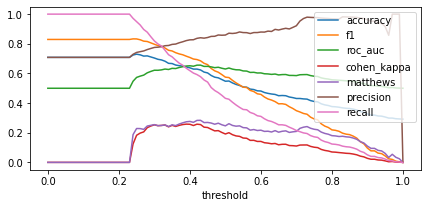

tn: max 203 at threshold 0.97
tn: min 0 at threshold 0.0
fp: max 203 at threshold 0.0
fp: min 0 at threshold 0.97
fn: max 493 at threshold 1.0
fn: min 0 at threshold 0.0
tp: max 493 at threshold 0.0
tp: min 0 at threshold 1.0
error_rate: max 493 at threshold 1.0
error_rate: min 188 at threshold 0.25


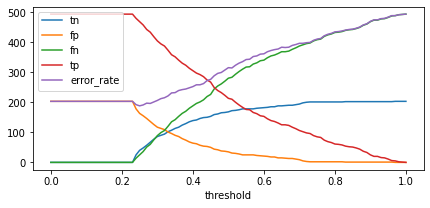

In [237]:
y_pred = np.array(list(map(lambda x: [1-x[0], x[0]], model.predict_proba(X_test))))
pred_metrics = get_print_binary_metrics(y_test, y_pred)

In [242]:
get_binary_metrics_for_threshold(pred_metrics, 0.28)

accuracy: 0.7183908045977011
f1: 0.815442561205273
roc_auc: 0.6041727035641843
cohen_kappa: 0.23412569195701727
matthews: 0.2451869865497618
precision: 0.7609841827768014
recall: 0.8782961460446247
tn: 67
fp: 136
fn: 60
tp: 433
error_rate: 196
